In [19]:
import geopandas as gpd
import pandas as pd
import networkx as nx
import osmnx as ox
import contextily as cx
import numpy as np
import joblib
import math
from pyrosm import OSM, get_data

C:\Users\jcarv\Documents\FEUP\M2ano\MS\MS-FEUP\venv\Lib\site-packages\pyrosm\networks.py:37: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  edges, nodes = prepare_geodataframe(


<Axes: >

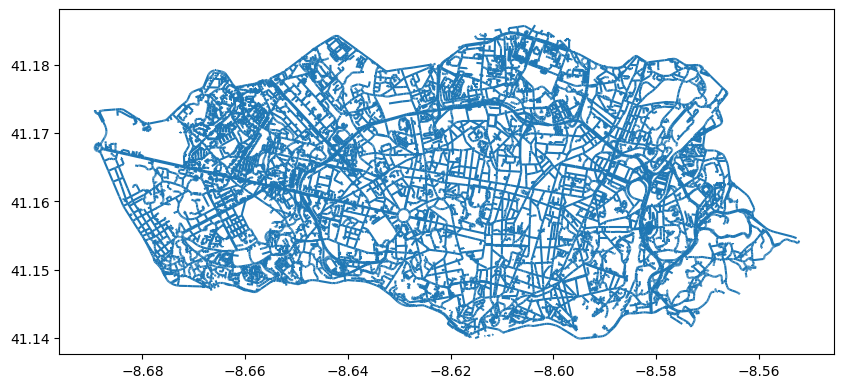

In [20]:
osm_fp = "./openstreetmap data/porto.osm.pbf"
# We will use test data for Helsinki that comes with pyrosm
osm = OSM(osm_fp)

# Parse roads that can be driven by car
roads = osm.get_network(network_type="driving")
roads.plot(figsize=(10,10))

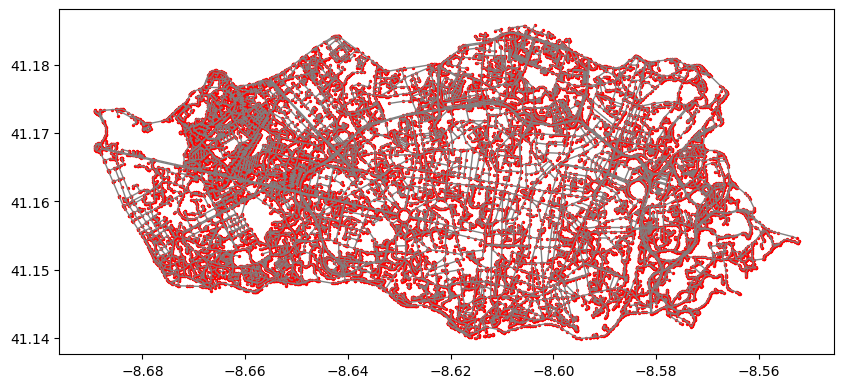

In [3]:
# Parse nodes and edges
road_nodes, road_edges = osm.get_network(network_type="driving", nodes=True)

# Plot the data
ax = road_edges.plot(figsize=(10,10), color="gray", lw=1.0)
ax = road_nodes.plot(ax=ax, color="red", markersize=2)

In [49]:
data_folder = "./openstreetmap data/"
stcp_nodes = gpd.read_file(data_folder + "stcp_nodes.gpkg")
stcp_edges = gpd.read_file(data_folder + "stcp_edges.gpkg")
metro_nodes = gpd.read_file(data_folder + "metro_nodes.gpkg")
metro_edges = gpd.read_file(data_folder + "metro_edges.gpkg")

stcp_nodes.crs = "EPSG:4326"
stcp_edges.crs = "EPSG:4326"
metro_edges.crs = "EPSG:4326"
metro_nodes.crs = "EPSG:4326"

G = osm.to_graph(stcp_nodes, stcp_edges, graph_type="networkx")

In [50]:
ox.plot_graph_folium(G)


C:\Users\jcarv\AppData\Local\Temp\ipykernel_23028\4128721249.py:1: FutureWarning: The `folium` module has been deprecated and will be removed in the v2.0.0 release. You can generate and explore interactive web maps of graph nodes, edges, and/or routes automatically using GeoPandas.GeoDataFrame.explore instead, for example like: `ox.graph_to_gdfs(G, nodes=False).explore()`. See the OSMnx examples gallery for complete details and demonstrations.
  ox.plot_graph_folium(G)


In [12]:
# Origin
orig_address = "Av. da Boavista 604-610, 4149-071 Porto"
orig_y, orig_x = ox.geocode(orig_address)  # notice the coordinate order (y, x)!

# Destination
dest_address = "Rua D. Frei Vicente da Soledade e Castro, Porto"
dest_y, dest_x = ox.geocode(dest_address) 

print("Origin coords:", orig_x, orig_y)
print("Destination coords:", dest_x, dest_y)

Origin coords: -8.6307703 41.1590784
Destination coords: -8.598334783806017 41.1776997243421


In [13]:
# 1. Find the closest nodes for origin and destination
orig_node_id, dist_to_orig = ox.distance.nearest_nodes(G, X=orig_x, Y=orig_y, return_dist=True)
dest_node_id, dist_to_dest = ox.distance.nearest_nodes(G, X=dest_x, Y=dest_y, return_dist=True)

print("Origin node-id:", orig_node_id, "and distance:", dist_to_orig, "meters.")
print("Destination node-id:", dest_node_id, "and distance:", dist_to_dest, "meters.")

Origin node-id: BCM4 and distance: 51.74511646938983 meters.
Destination node-id: FEUP2 and distance: 157.7244153477641 meters.


In [ ]:
# Calculate the paths
metric_path = nx.dijkstra_path(G, source=orig_node_id, target=dest_node_id, weight='length')
time_path = nx.dijkstra_path(G, source=orig_node_id, target=dest_node_id, weight='travel_time_seconds')

# Get also the actual travel times (summarize)
travel_length = nx.dijkstra_path_length(G, source=orig_node_id, target=dest_node_id, weight='length')
travel_time = nx.dijkstra_path_length(G, source=orig_node_id, target=dest_node_id, weight='travel_time_seconds')

In [ ]:
fig, ax = ox.plot_graph_route(G, metric_path)  # ou time_path

# Add the travel time as title
ax.set_xlabel("Shortest path distance {t: .1f} meters.".format(t=travel_length))

In [ ]:
ox.plot_route_folium(G, metric_path)  # visualização diferente da mesma coisa


In [4]:
sections = gpd.read_file(data_folder + "sections.gpkg")
# sections.crs = "EPSG:4326"

# sections.geometry = sections.geometry.centroid
# rename column DTMNFRSEC21 to id
sections.rename(columns={'DTMNFRSEC21': 'id'}, inplace=True)

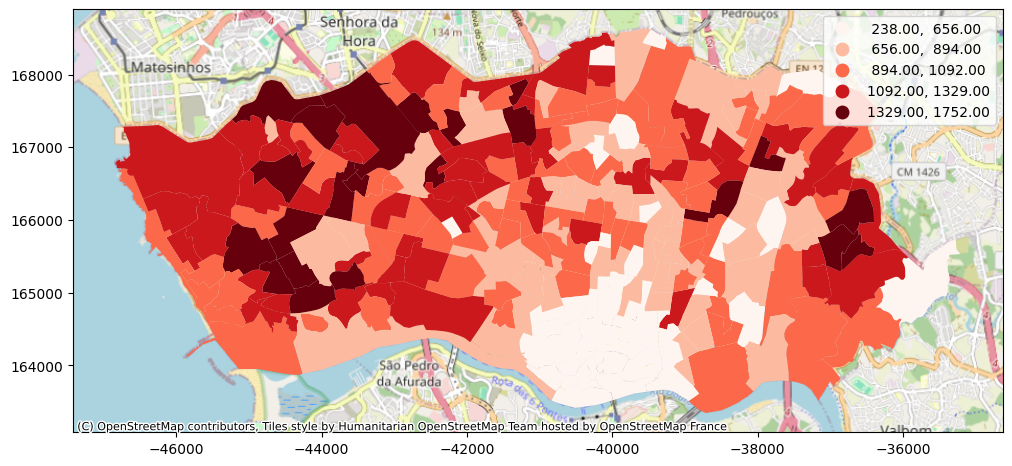

In [23]:
ax = sections.plot("N_INDIVIDUOS", scheme="natural_breaks", cmap="Reds", figsize=(12,12), legend=True, markersize=3.5)
cx.add_basemap(ax, crs=sections.crs)

In [5]:
# matrix = pd.DataFrame({'from_id': sections['id'].values.repeat(len(sections)), 'to_id': np.tile(sections['id'].values, len(sections))})
# ...

matrix = joblib.load(data_folder + 'matrix.pkl')

In [31]:
matrix

from_id      to_id  \
0      131217050  131217050   
1      131217050  131217049   
2      131217050  131203025   
3      131217050  131203017   
4      131217050  131217028   
...          ...        ...   
59044  131202012  131202001   
59045  131202012  131217017   
59046  131202012  131211033   
59047  131202012  131202014   
59048  131202012  131202012   

                                             metric_path  \
0                                                   None   
1                                       [PISC, BSB, BCG]   
2      [PISC, AQL1, FG1, MPL7, TXP1, SCR1, MAV2, IANT...   
3      [PISC, AQL1, FG1, MPL7, TXP1, SCR1, MAV2, IANT...   
4                                   [PISC, BSB, BCG, SP]   
...                                                  ...   
59044  [BFM4, C24A5, DJOA4, BLM, MCBL3, PRDJ, AL3, MS...   
59045        [BFM4, C24A5, DJOA4, BLM, BLFZ1, JN3, TRD5]   
59046  [BFM4, C24A5, DJOA4, BLM, BLFZ1, JN3, PRR1, FI...   
59047            [BFM4, C24A5, DJOA4, RFZ1, MOR2, ESCN2]   
59048                                               None   

                                            metric_path2  
0                                                   None  
1                                       [PISC, BSB, BCG]  
2      [PISC, AQL1, FG1, MPL7, TXP1, SCR1, MAV2, IANT...  
3      [PISC, AQL1, FG1, MPL7, TXP1, SCR1, MAV2, IANT...  
4                                   [PISC, BSB, BCG, SP]  
...                                                  ...  
59044  [BFM4, C24A5, DJOA4, BLM, MCBL3, PRDJ, AL3, MS...  
59045        [BFM4, C24A5, DJOA4, BLM, BLFZ1, JN3, TRD5]  
59046  [BFM4, C24A5, DJOA4, BLM, BLFZ1, JN3, PRR1, FI...  
59047            [BFM4, C24A5, DJOA4, RFZ1, MOR2, ESCN2]  
59048                                               None  

[59049 rows x 4 columns]

metric_path é de ter corrido o djikstra entre todos os nós e guardado o caminho mais curto entre cada par de nós (demorou 6 horas e o topo da rede estava cortada/interrompida)

metric_path2 é de ter corrido o floyd_warshall e guardado o caminho mais curto entre cada par de nós
(demorou menos de 10 minutos)

In [30]:
sections_nearest = sections.copy()
sections_nearest['nearest_node'] = sections.apply(lambda x: ox.distance.nearest_nodes(G, x.geometry.centroid.x, x.geometry.centroid.y), axis=1)

In [ ]:
# demora uns 5 min a correr

floyd_predecessors, floyd_distances = nx.floyd_warshall_predecessor_and_distance(G, weight='length')

Join Bus with Metro

In [10]:
a = None
for _, metro_node in metro_nodes.iterrows():
    a = metro_node
    break
a

id                                 5697
timestamp    2024-11-16 14:13:07.127000
tags                              metro
visible                            True
version                               1
lon                           -8.598349
lat                             41.1488
changeset                             1
geometry      POINT (-8.598349 41.1488)
Name: 0, dtype: object

In [33]:
" show first nodes of G"
for i, node in enumerate(G.nodes(data=True)):
    print(node)
    if i == 10:
        break

('1ADA1', {'osmid': '1ADA1', 'timestamp': Timestamp('2024-11-16 14:31:45.227000'), 'tags': 'bus', 'visible': True, 'version': 1, 'x': -8.61355552858081, 'y': 41.1716440199193, 'changeset': 1, 'geometry': <POINT (-8.614 41.172)>})
('1AL2', {'osmid': '1AL2', 'timestamp': Timestamp('2024-11-16 14:31:45.227000'), 'tags': 'bus', 'visible': True, 'version': 1, 'x': -8.6100690279121, 'y': 41.1495147366521, 'changeset': 1, 'geometry': <POINT (-8.61 41.15)>})
('1AL6', {'osmid': '1AL6', 'timestamp': Timestamp('2024-11-16 14:31:45.227000'), 'tags': 'bus', 'visible': True, 'version': 1, 'x': -8.6100096776489, 'y': 41.1491175343024, 'changeset': 1, 'geometry': <POINT (-8.61 41.149)>})
('1BS2', {'osmid': '1BS2', 'timestamp': Timestamp('2024-11-16 14:31:45.227000'), 'tags': 'bus', 'visible': True, 'version': 1, 'x': -8.62776236753369, 'y': 41.155925167507, 'changeset': 1, 'geometry': <POINT (-8.628 41.156)>})
('1BS3', {'osmid': '1BS3', 'timestamp': Timestamp('2024-11-16 14:31:45.227000'), 'tags': 'bu

In [48]:
# for all nodes in the metro network, find the nearest node in the bus network and add a walking edge


for _, metro_node in metro_nodes.iterrows():
    # {'id': stops['stop_code'], 'geometry': gpd.points_from_xy(stops['stop_lon'], stops['stop_lat']), 'timestamp': datetime.datetime.now(), 'tags': 'bus', 'visible': True, 'version': 1, 'lon': stops['stop_lon'], 'lat': stops['stop_lat'], 'changeset': 1}
    new_node = {'id': metro_node['id'], 'geometry': metro_node['geometry'], 'timestamp': pd.Timestamp.now(), 'tags': 'metro', 'visible': True, 'version': 1, 'lon': metro_node['lon'], 'lat': metro_node['lat'], 'changeset': 1}
    nearest_node, dist = ox.distance.nearest_nodes(G, X=metro_node['lon'], Y=metro_node['lat'], return_dist=True)
    # add the node to the graph
    G.add_nodes_from([(new_node['id'], new_node)])
    # G.add_edge(nearest_node, new_node['id'], length=dist, travel_time_seconds=dist/1.4)

ValueError: Input contains NaN.

In [32]:
# plot
ox.plot_graph_folium(G)


C:\Users\jcarv\AppData\Local\Temp\ipykernel_23028\4050246771.py:2: FutureWarning: The `folium` module has been deprecated and will be removed in the v2.0.0 release. You can generate and explore interactive web maps of graph nodes, edges, and/or routes automatically using GeoPandas.GeoDataFrame.explore instead, for example like: `ox.graph_to_gdfs(G, nodes=False).explore()`. See the OSMnx examples gallery for complete details and demonstrations.
  ox.plot_graph_folium(G)
